In [182]:
%%capture
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import pandas as pd

from tensorflow.keras import layers, optimizers
from collections import deque
from matplotlib.ticker import MaxNLocator
from math import prod, pow

SEED = 111

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [191]:
DATASET = 'mnist'
# DATASET = 'cifar10'

if DATASET == 'mnist':
    DATASET_PARAMS = dict(
        input_shape=(28, 28, 3),
        n_classes=10,
        baseline_accuracy=.3,
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:5%]', 'train[95%:]'],
        as_supervised=True
    )

    gray_to_rgb = lambda image, label: (tf.repeat(image, 3, axis=-1), label)
    train_ds = train_ds.map(gray_to_rgb)
    val_ds = val_ds.map(gray_to_rgb)
elif DATASET == 'cifar10':
    DATASET_PARAMS = dict(
        input_shape=(32, 32, 3),
        n_classes=10,
        baseline_accuracy=.1,
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:10%]', 'train[90%:]'],
        as_supervised=True
    )

In [219]:
CHILD_PARAMS = dict(
    epochs=1,
    batch_size=128,
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    rolling_accuracies_window=20,
    max_branch_length=2,
    blocks=5,
    cells=2,
    initial_width=1,
    initial_channels=4
)

STATE_SPACE = [
    dict(name='hidden_state', values=list(range(2)), count=2),
    dict(
        name='operations',
        values=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity'],
        count=2
    ),
    dict(name='combination', values=['add', 'concat'], count=1),
]

class CNNCell():
    def __init__(self, stride=1, channels=64):
        self.channels = channels
        self.stride = stride
        self.kwargs = dict(strides=(1, 1), padding='same')
    
    def repair_channels(self, inp):
        return layers.Conv2D(self.channels, 1, padding='same')(inp)

    def repair_branches(self, branches):
        (hidden_1, width_1), (hidden_2, width_2) = branches

        if width_1 != width_2:
            hidden_1 = layers.Conv2D(
                self.channels,
                3,
                strides=(2,2),
                padding='same'
            )(hidden_1)
        else:
            hidden_1 = self.repair_channels(hidden_1)
        
        hidden_2 = self.repair_channels(hidden_2)
        
        return [hidden_1, hidden_2]
    
    def reduce_inputs(self, inputs):
        if self.stride == 2:
            inputs = list(map(
                lambda inp: layers.Conv2D(self.channels, 3, strides=(2,2), padding='same')(inp),
                inputs
            ))
        
        return inputs
    
    def apply_op(self, op_id, inp):
        # print('Operation: ', STATE_SPACE[1]['values'][op_id])

        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **self.kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **self.kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **self.kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **self.kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **self.kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
        # print('Combination: ', STATE_SPACE[2]['values'][op_id])
        
        if op_id == 0:
            # Addition Operation
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_1, input_2 = list(map(lambda idx: inputs[idx], block_config[:2]))
        op1, op2 = block_config[2:4]
        combine_op = block_config[-1]

        # print('Input_1:', input_1.name, 'Input_2:', input_2.name)
        output = self.combination(
            combine_op,
            self.apply_op(op1, input_1),
            self.apply_op(op2, input_2)
        )

        return output

    def make_cell(self, cell_config, branches):
        inputs = self.repair_branches(branches)
        inputs = self.reduce_inputs(inputs)

        blocks = []
        for block in cell_config:
            # print('Block Config:', block)
            block_output = self.compose_block(block, inputs)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        output = self.repair_channels(x)

        return output

class ChildManager():
    def __init__(self):
        self.tds = CHILD_PARAMS['train_ds'].shuffle(
            500,
            reshuffle_each_iteration=True
        ).batch(CHILD_PARAMS['batch_size'])
        self.vds = CHILD_PARAMS['val_ds'].batch(256)

        self.past_accuracies = deque(maxlen=CHILD_PARAMS['rolling_accuracies_window'])
        self.past_accuracies.append(DATASET_PARAMS['baseline_accuracy'])

        # self.layers = [(0, 1)]
        self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]

    def make_child(self, config):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        width = CHILD_PARAMS['initial_width']
        branches = deque(maxlen=CHILD_PARAMS['max_branch_length'])
        branches.append((x, width))
        branches.append((x, width))

        for cell_type, stride in self.layers:
            width *= stride
            cnn_cell = CNNCell(
                stride,
                channels=CHILD_PARAMS['initial_channels']**width
            )

            x = cnn_cell.make_cell(config[cell_type], branches)
            branches.append((x, width))

        x = layers.GlobalAveragePooling2D()(x)
        # x = layers.Flatten()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=CHILD_PARAMS['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        model.summary()

        return model
    
    def train(self, model):
        history = model.fit(self.tds, validation_data=self.vds, epochs=CHILD_PARAMS['epochs'])
        accuracy = max(history.history['val_accuracy'])

        return accuracy
    
    def get_rewards(self, config):
        model = self.make_child(config)
        accuracy = self.train(model)

        self.past_accuracies.append(accuracy)
        rolling_accuracy = (sum(self.past_accuracies)/len(self.past_accuracies))
        reward = accuracy - rolling_accuracy

        return reward, accuracy

CONTROLLER_PARAMS = dict(
    exploration=0.2,
    hidden_size=32,
    episodes=2,
    learning_rate=0.001,
)

BLOCK_TIMESTEPS = sum(map(lambda x: x['count'], STATE_SPACE))
CELL_TIMESTEPS = BLOCK_TIMESTEPS*CHILD_PARAMS['blocks']
TOTAL_TIMESTEPS = CELL_TIMESTEPS*CHILD_PARAMS['cells']
STATE_ID_TO_STATE_SPACE_ID = {0:0, 1:0, 2:1, 3:1, 4:2}

TIMESTEP_ADDRESS_SPACE = (
    CHILD_PARAMS['cells'],
    CHILD_PARAMS['blocks'],
    len(STATE_ID_TO_STATE_SPACE_ID)
)
TIMESTEP_ADDRESSES = np.stack(
    np.unravel_index(range(TOTAL_TIMESTEPS),TIMESTEP_ADDRESS_SPACE),
    -1
)

STATE_ADDRESSES = list(map(
    lambda x: [x[0], x[1], STATE_ID_TO_STATE_SPACE_ID[x[2]]],
    TIMESTEP_ADDRESSES
))

class Controller():
    def __init__(self):
        self.rnn = self.make_rnn()
        self.store = dict(children=[], rewards=[], accuracies=[])
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.optimizer = optimizers.Adam(
            learning_rate=CONTROLLER_PARAMS['learning_rate']
        )

    def make_rnn(self):
        start_state = tf.keras.Input(shape=(), dtype=tf.int32)
        rnn_cell = tfa.rnn.NASCell(CONTROLLER_PARAMS['hidden_size'])

        initial_data = {
            'cell_state': [
                tf.zeros((1, CONTROLLER_PARAMS['hidden_size']), dtype=tf.float32),
                tf.zeros((1, CONTROLLER_PARAMS['hidden_size']), dtype=tf.float32)
            ],
            'embeddings': tf.keras.layers.Embedding(
                len(STATE_SPACE[0]['values']),
                CONTROLLER_PARAMS['hidden_size']
            )
        }

        prev_output = initial_data['embeddings'](start_state)
        prev_cell_state = initial_data['cell_state']
        predictions = []

        print('Controller Timesteps: ', TOTAL_TIMESTEPS)

        for timestep, (cell, block, state) in enumerate(STATE_ADDRESSES):
            prev_output, prev_cell_state = rnn_cell(prev_output, prev_cell_state)

            prediction_layer = tf.keras.layers.Dense(
                len(STATE_SPACE[state]['values']),
                activation='softmax',
                name='softmax_%d'%timestep
            )
            pred_action = prediction_layer(prev_output)
            predictions.append(pred_action)
        
        model = tf.keras.Model(inputs=start_state, outputs=predictions)
        # model.summary()

        return model
    
    def predict_child(self, start_state):
        # if .1 < CONTROLLER_PARAMS['exploration']:
        if np.random.random() < CONTROLLER_PARAMS['exploration']:
            def sample_state_space(x):
                (_, __, state_id) = x
                return random.randrange(len(STATE_SPACE[state_id]['values']))
    
            predictions = list(map(
                sample_state_space,
                STATE_ADDRESSES
            ))
            print(
                'Random Predictions:',
                np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)
            )
        else:
            predictions = self.rnn([start_state])
            predictions = list(map(lambda x: np.argmax(x), predictions))

            print(
                'RNN Predictions:',
                np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)
            )

        return predictions
    
    def save_trial(self, child, reward, accuracy):
        self.store['children'].append(child)
        self.store['rewards'].append(reward)
        self.store['accuracies'].append(accuracy)
    
    def train_step(self):
        child_config = self.store['children'][-1]
        reward = self.store['rewards'][-1]
        start_state = np.array([child_config[0]])

        with tf.GradientTape() as tape:
            outputs = controller.rnn(start_state)
            loss = 0.

            for index, output in enumerate(outputs):
                y_true = [child_config[index]]
                loss += self.loss_fn(y_true, output)
            
            grads = tape.gradient(loss, controller.rnn.trainable_variables)
            
            for index, grad in enumerate(grads):
                grads[index] = tf.multiply(grad, reward)

            self.optimizer.apply_gradients(
                zip(grads, controller.rnn.trainable_variables)
            )

controller = Controller()
# controller.predict_child(0)
# controller.rnn(np.array([0]))
# controller.train_step()

child_manager = ChildManager()
start_state = np.array([random.randrange(len(STATE_SPACE[0]))])

for episode in range(CONTROLLER_PARAMS['episodes']):
    predictions = controller.predict_child(start_state)
    
    config = np.array(predictions).reshape(TIMESTEP_ADDRESS_SPACE)
    print('Episode: {} Child Config: {}'.format(episode, config))

    # Evaluate the child generated by the controller
    reward, accuracy = child_manager.get_rewards(config)
    print(
        'Episode: {} Reward: {} Accuracy: {}'.format(
            episode,
            reward,
            accuracy
        )
    )

    # Store predicted child and its rewards
    controller.save_trial(predictions, reward, accuracy)
    
    # Train the Controller
    controller.train_step()

    # Update start_state for next episode.
    start_state = np.array([predictions[0]])
    tf.print('Start State:', start_state)

Controller Timesteps:  50
RNN Predictions: [[[1 0 4 3 1]
  [1 1 5 3 0]
  [1 1 3 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
Episode: 0 Child Config: [[[1 0 4 3 1]
  [1 1 5 3 0]
  [1 1 3 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
Model: "model_141"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_192 (InputLayer)         [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 rescaling_67 (Rescaling)       (None, 28, 28, 3)    0           ['input_192[0][0]']              
                                                                                                  
 conv2d_655 (Conv2D)           

2022-10-14 15:04:21.981641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 2.1186 - accuracy: 0.2063

2022-10-14 15:04:30.356053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 12s 332ms/step - loss: 2.1186 - accuracy: 0.2063 - val_loss: 1.8258 - val_accuracy: 0.3563
Episode: 0 Reward: 0.0281666576862335 Accuracy: 0.35633331537246704
Start State: array([1])
RNN Predictions: [[[1 0 4 3 1]
  [1 1 5 3 0]
  [1 1 3 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
Episode: 1 Child Config: [[[1 0 4 3 1]
  [1 1 5 3 0]
  [1 1 3 1 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
Model: "model_142"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_193 (InputLayer)         [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 rescaling_68 (Rescaling)      

2022-10-14 15:04:35.703680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 2.0825 - accuracy: 0.2350

2022-10-14 15:04:43.349866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 12s 339ms/step - loss: 2.0825 - accuracy: 0.2350 - val_loss: 1.7945 - val_accuracy: 0.3620
Episode: 1 Reward: 0.022555553913116422 Accuracy: 0.3619999885559082
Start State: array([1])


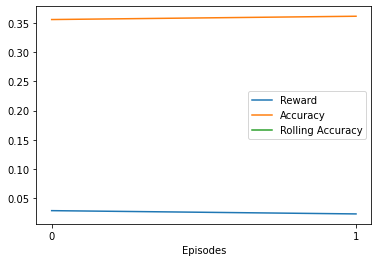

In [221]:
accuracies_df = pd.DataFrame(controller.store['accuracies'])
rolling_accuracies = accuracies_df.rolling(CHILD_PARAMS['rolling_accuracies_window']).mean()[0].tolist()

plt.plot(controller.store['rewards'], label='Reward')
plt.plot(controller.store['accuracies'], label='Accuracy')
plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Episodes')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

In [230]:
child_configs = controller.store['children']
df = pd.DataFrame(child_configs)
df['Accuracy'] = controller.store['accuracies']
df.index.name = 'Episodes'
df.columns.name = 'Timesteps'

def column_summary(df, column):
    column_df = df[[column, 'Accuracy']].groupby(column)
    column_stats = column_df.mean()
    column_stats['Counts'] = column_df.count()
    return column_stats

display(df)
for layer_id in range(TOTAL_TIMESTEPS):
    display(column_summary(df, layer_id))

Timesteps,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Accuracy
Episodes,,,,,,,,,,,,,,,,,,,,,
0,1,0,4,3,1,1,1,5,3,0,...,0,0,0,0,0,0,0,0,0,0.356333
1,1,0,4,3,1,1,1,5,3,0,...,0,0,0,0,0,0,0,0,0,0.362000


Timesteps,Accuracy,Counts
0,,
1,0.359167,2


Timesteps,Accuracy,Counts
1,,
0,0.359167,2


Timesteps,Accuracy,Counts
2,,
4,0.359167,2


Timesteps,Accuracy,Counts
3,,
3,0.359167,2


Timesteps,Accuracy,Counts
4,,
1,0.359167,2


Timesteps,Accuracy,Counts
5,,
1,0.359167,2


Timesteps,Accuracy,Counts
6,,
1,0.359167,2


Timesteps,Accuracy,Counts
7,,
5,0.359167,2


Timesteps,Accuracy,Counts
8,,
3,0.359167,2


Timesteps,Accuracy,Counts
9,,
0,0.359167,2


Timesteps,Accuracy,Counts
10,,
1,0.359167,2


Timesteps,Accuracy,Counts
11,,
1,0.359167,2


Timesteps,Accuracy,Counts
12,,
3,0.359167,2


Timesteps,Accuracy,Counts
13,,
1,0.359167,2


Timesteps,Accuracy,Counts
14,,
0,0.359167,2


Timesteps,Accuracy,Counts
15,,
0,0.359167,2


Timesteps,Accuracy,Counts
16,,
0,0.359167,2


Timesteps,Accuracy,Counts
17,,
0,0.359167,2


Timesteps,Accuracy,Counts
18,,
0,0.359167,2


Timesteps,Accuracy,Counts
19,,
0,0.359167,2


Timesteps,Accuracy,Counts
20,,
0,0.359167,2


Timesteps,Accuracy,Counts
21,,
0,0.359167,2


Timesteps,Accuracy,Counts
22,,
0,0.359167,2


Timesteps,Accuracy,Counts
23,,
0,0.359167,2


Timesteps,Accuracy,Counts
24,,
0,0.359167,2


Timesteps,Accuracy,Counts
25,,
0,0.359167,2


Timesteps,Accuracy,Counts
26,,
0,0.359167,2


Timesteps,Accuracy,Counts
27,,
0,0.359167,2


Timesteps,Accuracy,Counts
28,,
0,0.359167,2


Timesteps,Accuracy,Counts
29,,
0,0.359167,2


Timesteps,Accuracy,Counts
30,,
0,0.359167,2


Timesteps,Accuracy,Counts
31,,
0,0.359167,2


Timesteps,Accuracy,Counts
32,,
0,0.359167,2


Timesteps,Accuracy,Counts
33,,
0,0.359167,2


Timesteps,Accuracy,Counts
34,,
0,0.359167,2


Timesteps,Accuracy,Counts
35,,
0,0.359167,2


Timesteps,Accuracy,Counts
36,,
0,0.359167,2


Timesteps,Accuracy,Counts
37,,
0,0.359167,2


Timesteps,Accuracy,Counts
38,,
0,0.359167,2


Timesteps,Accuracy,Counts
39,,
0,0.359167,2


Timesteps,Accuracy,Counts
40,,
0,0.359167,2


Timesteps,Accuracy,Counts
41,,
0,0.359167,2


Timesteps,Accuracy,Counts
42,,
0,0.359167,2


Timesteps,Accuracy,Counts
43,,
0,0.359167,2


Timesteps,Accuracy,Counts
44,,
0,0.359167,2


Timesteps,Accuracy,Counts
45,,
0,0.359167,2


Timesteps,Accuracy,Counts
46,,
0,0.359167,2


Timesteps,Accuracy,Counts
47,,
0,0.359167,2


Timesteps,Accuracy,Counts
48,,
0,0.359167,2


Timesteps,Accuracy,Counts
49,,
0,0.359167,2


In [223]:
child_configs = list(
    map(
        convert_controller_preds_to_child_config,
        controller.store['children']
    )
)
layer_id_to_name = lambda x: 'Layer %d'%x
columns = list(map(layer_id_to_name, range(DATASET_PARAMS['n_layers'])))

df['Accuracy'] = controller.store['accuracies']
df.index.name = 'Episodes'

def column_summary(df, column):
    column_df = df[[column, 'Accuracy']].groupby(column)
    column_stats = column_df.mean()
    column_stats['Counts'] = column_df.count()
    return column_stats

display(df)
# for layer_id in range(DATASET_PARAMS['n_layers']):
#     display(column_summary(df, layer_id_to_name(layer_id)))

ValueError: invalid literal for int() with base 10: 'max_3x3'

In [232]:
pd.read_csv('nasnet_stats.csv')

,Episodes,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,Accuracy
0,0,1,0,4,3,1,1,1,5,3,...,0,0,0,0,0,0,0,0,0,0.356333
1,1,1,0,4,3,1,1,1,5,3,...,0,0,0,0,0,0,0,0,0,0.362000
